In [1]:
from igraph import *
import networkx as nx
import random
import community as community_louvain
# import louvain
import os,sys
import time
import subprocess
from infomap import Infomap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cdlib import algorithms
import networkx as nx
from louvain_mod import *

In [2]:
def clique(g, size, idx, num_nodes):
  for i in range(idx,num_nodes-1):
    for j in range(idx - size,idx):
      g[i,j] = 0

In [3]:
def Print(g,num_nodes):
  G = nx.Graph()
  for i in range(num_nodes):
    G.add_node(i)
  for i in range(num_nodes):
    for j in range(i+1, num_nodes):
      if g[i,j] == 1:
        G.add_edge(i,j)
  nx.draw(G, with_labels=True)
def Print(total,edges):
  G = nx.Graph()
  for i in range(total):
    G.add_node(i)
  for i1 in edges:
    i = i1[0]
    j = i1[1]
    G.add_edge(i,j)
  nx.draw(G, with_labels=True)

In [4]:
def walktrap(g):
  k = g.community_walktrap()
  k = k.as_clustering()
  print(k)

In [5]:
def infomap(g):
  k = g.community_infomap()
  print(k)

In [6]:
def hub_node(clq):
    num_nodes = int((clq*(clq+1))/2) + 1
    g = Graph.Full(num_nodes)
    size = 0
    for i in range(clq,1,-1):
        size = size + i
        clique(g,i,size,num_nodes)
    walktrap(g)
    Print(g, num_nodes)
    infomap(g)

In [7]:
def hub_node2(clq):
    num_nodes = int(clq*(clq+1)) + 1
    g = Graph.Full(num_nodes)
    size = 0
    for i in range(clq,1,-1):
        size = size + i
        clique(g,i,size,num_nodes)
        size = size + i
        clique(g,i,size,num_nodes)
    g[num_nodes-2, num_nodes-3] = 0
    walktrap(g)
    Print(g, num_nodes)
    infomap(g)

In [8]:
def alt_hub_node(clq):
    num_nodes = int((clq+1)*(clq+1)/4) + 1
    g = Graph.Full(num_nodes)
    size = 0
    for i in range(clq,1,-2):
        size = size + i
        clique(g,i,size,num_nodes)
    walktrap(g)
    Print(g, num_nodes)
    infomap(g)

In [9]:
def creat_random_connected(offset,size,number_of_edges = 100000000):

    edges = []
    for i in range(size-1):
        edges.append((offset + i,offset + i + 1))
    edges.append((offset,offset + size - 1))
    ret_edges = edges[:];
    
    edges = []
    for i in range(size):
        for j in range(i + 1,size):
            if((offset + i,offset + j) not in ret_edges):
                edges.append((offset + i,offset + j))

    last = len(edges)-1
    for i in range(min(number_of_edges,len(edges))):
        ind = random.randint(0,last)
        ret_edges.append(edges[ind])
        tmp = edges[ind]
        edges[ind] = edges[last]
        edges[last] = tmp
        last -= 1
    return ret_edges

In [10]:
def ring_of_clique(ring_size , clique_size):

    total_vert = ring_size*clique_size;

    edges = creat_random_connected(0,clique_size);import random

    offset = clique_size
    prev_connector = offset - 1

    for i in range(ring_size - 1):
        new_clique = creat_random_connected(offset,clique_size);
        new_clique.append((prev_connector,offset))
        edges.extend(new_clique)
        offset += clique_size
        prev_connector += clique_size

    edges.append((0,prev_connector))

    return [total_vert, edges]


In [11]:
def line_star_graph(total_vert, line_length):
    edges = []

    for i in range(1,line_length):
        edges.append((i-1,i))

    middle_node = line_length//2
    rem_vert = total_vert - line_length
    offset = line_length

    for i in range(rem_vert):
        edges.append((middle_node,offset + i))

    return [total_vert, edges]

In [12]:
def run_louvain(total_vert,edges):
                
    g = Graph()
    g.add_vertices(total_vert)
    g.add_edges(edges)
    

    part = g.community_multilevel();
#     print(part)
    return part

In [13]:
def run_maxperm(total_vert, edges):
    try:
        returned_value = subprocess.check_output("rm input.dat", shell = True)
        returned_value = subprocess.check_output("rm output.txt", shell = True)
    except:
        it = 0
    input_file = open("input.dat", "w")
    input_file.write(str(total_vert) + " " + str(len(edges)) + "\n")
    for i in edges:
        m1 = i[0]
        m2 = i[1]
        input_file.write(str(m1) + " " + str(m2) + "\n")
#         input_file.write(str(m2) + " " + str(m1) + "\n")
    input_file.close()
    
    returned_value = subprocess.check_output("bash compile.sh", shell = True)
    returned_value = returned_value.decode("utf-8")
    
    #print(returned_value)
    
    output_file = open("output.txt","r")
    partitions = output_file.readlines() 

    dicti={}
#     print(partitions[:2])
    for line in partitions[2:]:
        #print(line.strip())
        pair = line.split('\t')
        pair = list(map(int,pair))
        if pair[1] in dicti:
            dicti[pair[1]].append(pair[0])
        else:
            dicti[pair[1]] = [pair[0]]
    try:
        returned_value = subprocess.check_output("rm input.dat", shell = True)
        returned_value = subprocess.check_output("rm output.txt", shell = True)
    except:
        it = 0
#     print("total partitions : " + str(len(dicti.keys())) )
#     for i in dicti.keys():
#         print ("[" + str(i) + "] : "),
#         print(list(dicti[i]))
    return dicti
    

In [14]:
def hub_surr_cliq(total_number_of_cliq,list_of_sizes):
    
    total_vert = sum(list_of_sizes) + 1
    offset = 1
    edges = []
    
    for i in range(total_number_of_cliq):
        edges.append((0,offset))
        edges.extend(creat_random_connected(offset,list_of_sizes[i]))
        offset += list_of_sizes[i]
        
    return [total_vert,edges]
def hub_surr_cliq2(total_number_of_cliq,list_of_sizes):
    
    total_vert = sum(list_of_sizes) + 1
    offset = 1
    edges = []
    for i in range(1,total_vert):
        edges.append((0,i))
    for i in range(total_number_of_cliq):
        edges.append((0,offset))
        edges.extend(creat_random_connected(offset,list_of_sizes[i]))
        offset += list_of_sizes[i]
        
    return [total_vert,edges]


In [15]:
def comm_surr_comm(middle_size,outer_size,count_outer,beta):
    edges = []

    if(middle_size < count_outer):
        print("add more vertices to middle comm")
        return None

#     g = Graph()
    total_vert = count_outer*outer_size + middle_size
#     g.add_vertices(total_vert)

    edges.extend(creat_random_connected(0,middle_size))
    
    offset = middle_size
    for i in range(count_outer):
        edges.extend(creat_random_connected(offset,outer_size))
        beta1 = beta
        for j in range(offset,offset + outer_size):
            if(beta1 == 0):
                break
            beta1 -= 1
            edges.append((i,j))
        offset += outer_size

    return [total_vert,edges]


In [16]:
def hub_node_graph(left_size,right_size):
    edges = []

#     g = Graph()
    total_vert = left_size + right_size + 1
#     g.add_vertices(total_vert)
    
    hub_node = 0
    offset_right = left_size + 1
    
    edges.extend(creat_random_connected(0,left_size + 1))
    edges.extend(creat_random_connected(offset_right,right_size))

    for i in range(right_size):
        edges.append((0,offset_right + i));
#     print(edges)
#     g.add_edges(edges)
    return [total_vert, edges]


In [17]:
def ring_of_clique_temp(ring_size , clique_list):

    total_vert = sum(clique_list);

    edges = creat_random_connected(0,clique_list[0]);

    offset = clique_list[0]
    prev_connector = offset - 1

    for i in range(1,ring_size):
        new_clique = creat_random_connected(offset,clique_list[i]);
        new_clique.append((prev_connector,offset))
        edges.extend(new_clique)
        offset += clique_list[i]
        prev_connector += clique_list[i]

    edges.append((0,prev_connector))

    return [total_vert, edges]

In [18]:
def run_infomap(total_vert,edges):
    im = Infomap("--two-level --directed")
#     im.add_link(0, 1)
    for i in edges:
        im.addLink(i[0],i[1])
        im.addLink(i[1],i[0])
    im.run()
    sets = {}

#     print("Found " + str(im.num_top_modules)+ " modules with codelength: " + str(im.codelength))
    print("Result")
    print("\n#node module")
    for node in im.tree:
        if node.is_leaf:
            if(node.module_id in sets):
                sets[node.module_id].append(node.node_id)
            else:
                sets[node.module_id] = [node.node_id]
            print(node.node_id, node.module_id)
    print("total partitions : " + str(len(sets.keys())) )
    for i in sets.keys():
        print ("[" + str(i) + "] : "),
        print(sets[i])
        
    g = Graph()
    g.add_vertices(total_vert)
    g.add_edges(edges)
    Print(g,total_vert)

In [19]:
def hub_node_generic(x,y,alpha,beta):
    total_vert = x + y + 1 + alpha + beta;
    x,y = y,x
    alpha,beta = beta,alpha
    x = x + alpha
    y = y + beta
    edges = creat_random_connected(1,y);
    offset = y + 1;
    edges.extend(creat_random_connected(offset,x));

    for i in range(1,y + 1):
        if(beta == 0):
            break
        edges.append((0,i))
        beta -= 1
    for i in range(y + 1,y + x + 1):
        if(alpha == 0):
            break
        edges.append((0,i))
        alpha -= 1

    return [total_vert, edges]

In [20]:
def run_label_prop(total_vert,edges):
    G = nx.Graph()
    G.add_nodes_from(range(total_vert))
    G.add_edges_from(edges)
#     nx.draw_networkx(G)
    cnt = 0;
    dict1 = {}
    for i in nx.algorithms.community.label_propagation.asyn_lpa_communities(G):
        dict1[cnt] = i
        cnt += 1
    return dict1
        
print(run_label_prop(4,[(0,1),(2,1),(0,2),(3,1)]))

{0: {0, 1, 2, 3}}


In [21]:
def run_spinglass(total_vert,edges,gam):
    G = Graph()
    G.add_vertices(total_vert)
    G.add_edges(edges)
    
    G_NX = nx.Graph()
    G_NX.add_nodes_from(range(total_vert))
    G_NX.add_edges_from(edges)
    e =  naive_greedy_modularity_communities(G_NX,gamma = gam);
    dict1 = {}
    cnt = 0
    for i in e:
        dict1[cnt] = list(i)
        cnt += 1
        
    return dict1

In [22]:
def run_louvain(total_vert,edges):
                
    g = Graph()
    g.add_vertices(total_vert)
    g.add_edges(edges)
    e = g.community_multilevel()
#     print(e)
    dict1 = {}
    cnt = 0
    for i in e:
        dict1[cnt] = list(i)
        cnt += 1
    return dict1

In [24]:
def run_spinglass_c(total_vert, edges,gamma):
    try:
        returned_value = subprocess.check_output("rm input.txt", shell = True)
        returned_value = subprocess.check_output("rm output.txt", shell = True)
    except:
        it = 0
    input_file = open("input.txt", "w")
    input_file.write(str(total_vert) + " " + str(len(edges)) + " " +  str(gamma) + "\n")
#     print(str(total_vert) + " " + str(len(edges)) +  str(gamma) + "\n")
    for i in edges:
        m1 = i[0]
        m2 = i[1]
        input_file.write(str(m1) + " " + str(m2) + "\n")
#         input_file.write(str(m2) + " " + str(m1) + "\n")
    input_file.close()
    
    returned_value = subprocess.check_output("./a.out < input.txt > output.txt", shell = True)
    returned_value = returned_value.decode("utf-8")
    
    #print(returned_value)
    
    output_file = open("output.txt","r")
    partitions = output_file.readlines() 
    
    l = partitions[0].split(" ")
    print(l)
    dicti = {}
    for i in range(total_vert):
        try:
            if(int(l[i]) in dicti):
                dicti[int(l[i])].append(i)
            else:
                dicti[int(l[i])] = [i]
        except:
            m = 0
    try:
        returned_value = subprocess.check_output("rm input.dat", shell = True)
        returned_value = subprocess.check_output("rm output.txt", shell = True)
    except:
        it = 0
#     print("total partitions : " + str(len(dicti.keys())) )
#     for i in dicti.keys():
#         print ("[" + str(i) + "] : "),
#         print(list(dicti[i]))
    return dicti
    

In [26]:
graph = hub_node_generic(19,19,3,3)
part = run_spinglass(graph[0],graph[1],7)
print(part)

{0: [0, 1], 1: [2], 2: [3], 3: [4], 4: [5], 5: [6], 6: [7], 7: [8], 8: [9], 9: [10], 10: [11], 11: [12], 12: [13], 13: [14], 14: [15], 15: [16], 16: [17], 17: [18], 18: [19], 19: [20], 20: [21], 21: [22], 22: [23], 23: [24], 24: [25], 25: [26], 26: [27], 27: [28], 28: [29], 29: [30], 30: [31], 31: [32], 32: [33], 33: [34], 34: [35], 35: [36], 36: [37], 37: [38], 38: [39], 39: [40], 40: [41], 41: [42], 42: [43], 43: [44]}


# SPINGLASS

### CASE 1: Varying x and y (btw 5 -24) with constant alpha = 50 and beta = 50

1 => hub node was merged with left community

0 => hub node was merged with right community

2 => whole graph was considered as one community


In [ ]:
x_val = [i for i in range(5,20)]
y_val = [i for i in range(5,20)]
y_val.reverse()
alpha = 3
beta = 3
matrix_ans = []
for j in y_val:
    temp = []
    print(j)
    for i in x_val:
        print(i,end = " ")
        graph = hub_node_generic(i,j,alpha,beta)
        part = run_spinglass(graph[0],graph[1],7)
        if(len(part) == 1):
            temp.append(2)
            continue;
#         if(len(part) > 3):
#             temp.append(3)
#             continue
        for i1 in part:
            if(0 in part[i1]):
                if(len(part[i1]) <= 3):
                    temp.append(3)
                elif(max(part[i1]) <= (i + alpha) and max(part[i1]) != 0):
                    temp.append(1)
                    break
                elif(max(part[i1]) <= (i + alpha + j + beta) and max(part[i1]) != 0):
                    temp.append(0)
                elif(max(part[i1]) == 0):
                    temp.append(3)
    print(len(temp),"len")
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("left clique size")
plt.ylabel("right clique size")
plt.show()

In [ ]:
x_val = [i for i in range(5,20)]
y_val = [i for i in range(5,20)]
y_val.reverse()
alpha = 3
beta = 3
matrix_ans = []
for j in y_val:
    temp = []
    print(j)
    for i in x_val:
        print(i,end = " ")
        graph = hub_node_generic(i,j,alpha,beta)
        part = run_spinglass(graph[0],graph[1],1)
        if(len(part) == 1):
            temp.append(2)
            continue;
#         if(len(part) > 3):
#             temp.append(3)
#             continue
        for i1 in part:
            if(0 in part[i1]):
                if(len(part[i1]) <= 3):
                    temp.append(3)
                elif(max(part[i1]) <= (i + alpha) and max(part[i1]) != 0):
                    temp.append(1)
                    break
                elif(max(part[i1]) <= (i + alpha + j + beta) and max(part[i1]) != 0):
                    temp.append(0)
                elif(max(part[i1]) == 0):
                    temp.append(3)
    print(len(temp),"len")
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("left clique size")
plt.ylabel("right clique size")
plt.show()

19
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
18
5 6 7 8 9 10 11 12 

19
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
18
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
17
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
16
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
15
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
14
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
13
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
12
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
11
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
10
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
9
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
8
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
7
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
6
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
5
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len


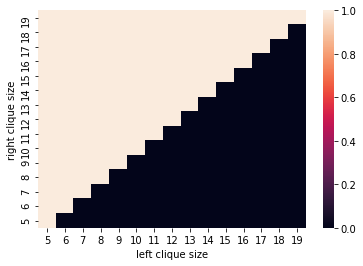

In [37]:
x_val = [i for i in range(5,20)]
y_val = [i for i in range(5,20)]
y_val.reverse()
alpha = 3
beta = 3
matrix_ans = []
for j in y_val:
    temp = []
    print(j)
    for i in x_val:
        print(i,end = " ")
        graph = hub_node_generic(i,j,alpha,beta)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == 1):
            temp.append(2)
            continue;
#         if(len(part) > 3):
#             temp.append(3)
#             continue
        for i1 in part:
            if(0 in part[i1]):
                if(len(part[i1]) <= 3):
                    temp.append(3)
                elif(max(part[i1]) <= (i + alpha) and max(part[i1]) != 0):
                    temp.append(1)
                    break
                elif(max(part[i1]) <= (i + alpha + j + beta) and max(part[i1]) != 0):
                    temp.append(0)
                elif(max(part[i1]) == 0):
                    temp.append(3)
    print(len(temp),"len")
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("left clique size")
plt.ylabel("right clique size")
plt.show()

19
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
18
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
17
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
16
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
15
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
14
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
13
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
12
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
11
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
10
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
9
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
8
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
7
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
6
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len
5
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 15 len


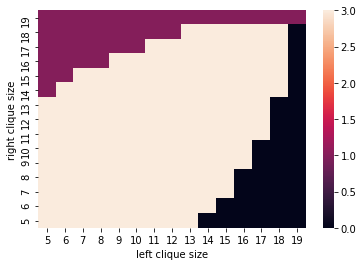

In [33]:
x_val = [i for i in range(5,20)]
y_val = [i for i in range(5,20)]
y_val.reverse()
alpha = 3
beta = 3
matrix_ans = []
for j in y_val:
    temp = []
    print(j)
    for i in x_val:
        print(i,end = " ")
        graph = hub_node_generic(i,j,alpha,beta)
        part = run_spinglass(graph[0],graph[1],7)
#         print(part)
        if(len(part) == 1):
            temp.append(2)
            continue;
#         if(len(part) >= 3):
#             temp.append(3)
#             continue;
        for i1 in part:
            if(0 in part[i1]):
                if(max(part[i1]) <= (i + alpha) and max(part[i1]) != 0):
                    temp.append(1)
                    break
                elif(max(part[i1]) <= (i + alpha + j + beta) and max(part[i1]) != 0):
                    temp.append(0)
                elif(max(part[i1]) == 0):
                    temp.append(3)
    print(len(temp),"len")
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("left clique size")
plt.ylabel("right clique size")
plt.show()

In [34]:
for i in range(100):
    graph = hub_node_generic(5,4,alpha,beta)
    part = run_spinglass(graph[0],graph[1],1)
    print(part,"sping")
    part = run_louvain(graph[0],graph[1])
    print(part,"louv")

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15]} sping
{0: [0, 9, 10, 11, 12, 13, 14, 15], 1: [1, 2, 3, 4, 5, 6, 7, 8]} louv
{0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15]} sping
{0: [0, 9, 10, 11, 12, 13, 14, 15], 1: [1, 2, 3, 4, 5, 6, 7, 8]} louv
{0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15]} sping
{0: [0, 9, 10, 11, 12, 13, 14, 15], 1: [1, 2, 3, 4, 5, 6, 7, 8]} louv
{0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15]} sping
{0: [0, 9, 10, 11, 12, 13, 14, 15], 1: [1, 2, 3, 4, 5, 6, 7, 8]} louv
{0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15]} sping
{0: [0, 9, 10, 11, 12, 13, 14, 15], 1: [1, 2, 3, 4, 5, 6, 7, 8]} louv
{0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15]} sping
{0: [0, 9, 10, 11, 12, 13, 14, 15], 1: [1, 2, 3, 4, 5, 6, 7, 8]} louv
{0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15]} sping
{0: [0, 9, 10, 11, 12, 13, 14, 15], 1: [1, 2, 3, 4, 5, 6, 7, 8]} louv
{0: [0, 1, 2,

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15]} sping
{0: [0, 9, 10, 11, 12, 13, 14, 15], 1: [1, 2, 3, 4, 5, 6, 7, 8]} louv
{0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15]} sping
{0: [0, 9, 10, 11, 12, 13, 14, 15], 1: [1, 2, 3, 4, 5, 6, 7, 8]} louv
{0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15]} sping
{0: [0, 9, 10, 11, 12, 13, 14, 15], 1: [1, 2, 3, 4, 5, 6, 7, 8]} louv
{0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15]} sping
{0: [0, 9, 10, 11, 12, 13, 14, 15], 1: [1, 2, 3, 4, 5, 6, 7, 8]} louv
{0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15]} sping
{0: [0, 9, 10, 11, 12, 13, 14, 15], 1: [1, 2, 3, 4, 5, 6, 7, 8]} louv
{0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15]} sping
{0: [0, 9, 10, 11, 12, 13, 14, 15], 1: [1, 2, 3, 4, 5, 6, 7, 8]} louv
{0: [0, 1, 2, 3, 4, 5, 6, 7, 8], 1: [9, 10, 11, 12, 13, 14, 15]} sping
{0: [0, 9, 10, 11, 12, 13, 14, 15], 1: [1, 2, 3, 4, 5, 6, 7, 8]} louv
{0: [0, 1, 2,

### CASE 2: Varying alpha and beta (btw 5 -24) with constant x = 50 and y = 50

1 => hub node was merged with left community

0 => hub node was merged with right community

2 => whole graph was considered as one community

https://www.desmos.com/calculator/gjm394ys6u

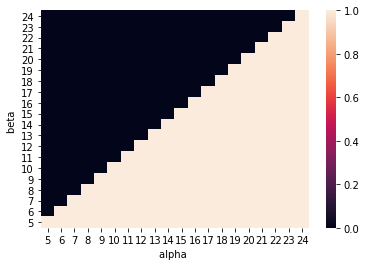

In [38]:
alpha_val = [i for i in range(5,25)]
beta_val = [i for i in range(5,25)]
beta_val.reverse()
x = 50
y = 50
matrix_ans = []
for beta in beta_val:
    temp = []
    for alpha in alpha_val:
        graph = hub_node_generic(x,y,alpha,beta)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == 1):
            temp.append(2)
            continue;
        if(0 in part[0] and 1 in part[0]):
            temp.append(1)
        elif(0  in part[1] and 1 in part[1]):
            temp.append(1)
        else:
            temp.append(0)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=alpha_val, yticklabels=beta_val)
plt.xlabel("alpha ")
plt.ylabel("beta ")
plt.show()

### CASE 3: Varying alpha and x  with constant y = 50 and beta = 10

x : 5 10 .. 100 

alpha : 5 - 50

1 => hub node was merged with left community

0 => hub node was merged with right community

2 => whole graph was considered as one community

https://www.desmos.com/calculator/gpxw3th3hk

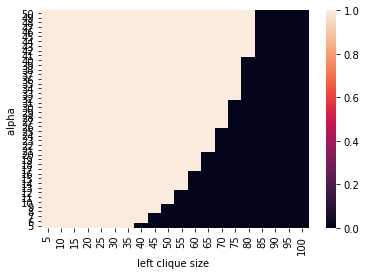

In [39]:
alpha_val = [i for i in range(5,51)]
x_val = [i*5 for i in range(1,21)]
alpha_val.reverse()
beta = 10
y = 50
matrix_ans = []
for alpha in alpha_val:
    temp = []
    for x in x_val:
        graph = hub_node_generic(x,y,alpha,beta)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == 1):
            temp.append(2)
            continue;
        if(0 in part[0] and 1 in part[0]):
            temp.append(1)
        elif(0  in part[1] and 1 in part[1]):
            temp.append(1)
        else:
            temp.append(0)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=alpha_val)
plt.xlabel("left clique size ")
plt.ylabel("alpha ")
plt.show()

## Maxperm

### CASE 1: Varying x and y  (btw 10 - 26) with constant alpha = 10 and beta = 10

1 => hub node was merged with left community

0 => hub node was merged with right community

2 => whole graph was considered as one community

https://www.desmos.com/calculator/6u1v2pp0iu

26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 

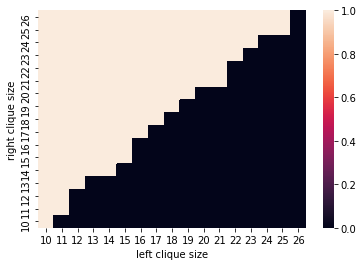

In [40]:
x_val = [i for i in range(10,27)]
y_val = [i for i in range(10,27)]
y_val.reverse()
alpha = 10
beta = 10
matrix_ans = []
for j in y_val:
    print (j,end = " ")
    temp = []
    for i in x_val:
        graph = hub_node_generic(i,j,alpha,beta)
        part = run_maxperm(graph[0],graph[1])
        if(len(part) == 1):
            temp.append(0)
            continue;
        for i1 in part.keys():
            if(0 in part[i1]):
                if(1 in part[i1]):
                    temp.append(1)
                else:
                    temp.append(0)
                break
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("left clique size")
plt.ylabel("right clique size")
plt.show()

{31: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]}


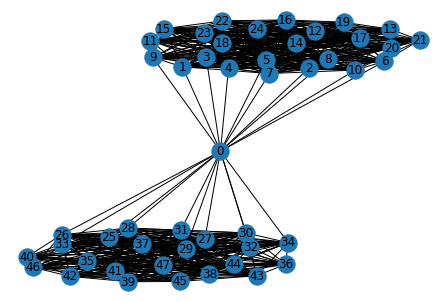

In [41]:
graph = hub_node_generic(14,13,10,10)
part = run_maxperm(graph[0],graph[1])
g = Graph()
g.add_vertices(graph[0])
g.add_edges(graph[1])
Print(g,graph[0])
print(part)

{1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 41: [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]}


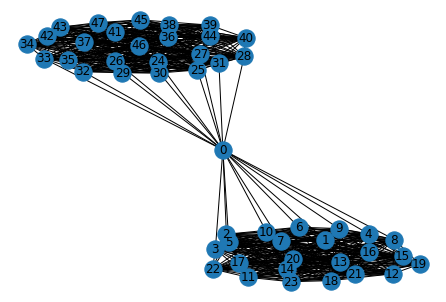

In [42]:
graph = hub_node_generic(13,14,10,10)
part = run_maxperm(graph[0],graph[1])
print(part)
g = Graph()
g.add_vertices(graph[0])
g.add_edges(graph[1])
Print(g,graph[0])

### CASE 2: Varying alpha and beta (btw 20 -31) with constant x = 10 and y = 10

1 => hub node was merged with left community

0 => hub node was merged with right community

2 => whole graph was considered as one community

https://www.desmos.com/calculator/orrw2gwjqr

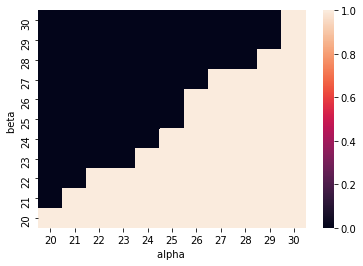

In [43]:
alpha_val = [i for i in range(20,31)]
beta_val = [i for i in range(20,31)]
beta_val.reverse();
x = 10
y = 10
matrix_ans = []
for beta in beta_val:
    temp = []
    for alpha in alpha_val:
        graph = hub_node_generic(x,y,alpha,beta)
        part = run_maxperm(graph[0],graph[1])
        if(len(part.keys()) == 1):
            temp.append(2)
            continue;
        for i1 in part.keys():
            if(0 in part[i1]):
                if(1 in part[i1]):
                    temp.append(1)
                else:
                    temp.append(0)
                break
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels = alpha_val, yticklabels= beta_val)
plt.xlabel("alpha ")
plt.ylabel("beta ")
plt.show()

### CASE 3: Varying alpha and x  with constant y = 10 and beta = 10

x : 10 - 20

alpha : 10 - 20

1 => hub node was merged with left community

0 => hub node was merged with right community

2 => whole graph was considered as one community

https://www.desmos.com/calculator/ngsfx64njq

20 19 18 17 16 15 14 13 12 11 10 

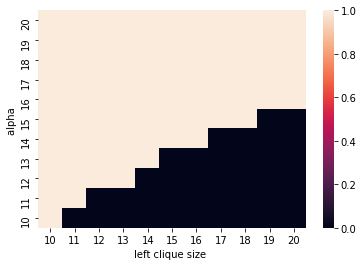

In [44]:
alpha_val = [i for i in range(10,21)]
x_val = [i for i in range(10,21)]
alpha_val.reverse()
beta = 10
y = 10
matrix_ans = []
for alpha in alpha_val:
    print(alpha,end = " ")
    temp = []
    for x in x_val:
        graph = hub_node_generic(x,y,alpha,beta)
        part = run_maxperm(graph[0],graph[1])
        if(len(part.keys()) == 1):
            temp.append(2)
            continue;
        for i1 in part.keys():
            if(0 in part[i1]):
                if(1 in part[i1]):
                    temp.append(1)
                else:
                    temp.append(0)
                break
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=alpha_val)
plt.xlabel("left clique size ")
plt.ylabel("alpha ")
plt.show()

# Ring of Cliques

## Modularity

x : between 55 , 60 ... 100, total ring size 

y : between 3 - 30, each clique size

1 => Some of the cliques were merged together

0 => None of the cliques were merged together

2 => not even those small cliques were identified correctly

https://www.desmos.com/calculator/sxkdlnz3tn

10 9 8 7 6 5 4 3 

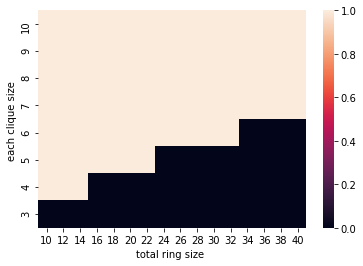

In [52]:
x_val = [i*2 for i in range(5,21)]
y_val = [i for i in range(3,11)]
y_val.reverse()
matrix_ans = []
for y in y_val:
    print(y,end = " ")
    temp = []
    for x in x_val:
        graph = ring_of_clique(x,y)
#         part = run_spinglass(graph[0],graph[1],1)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == x):
            temp.append(1)
        elif(len(part) < x):
            temp.append(0)
        else:
            temp.append(2)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("total ring size ")
plt.ylabel("each clique size ")
plt.show()

In [ ]:
x_val = [i*2 for i in range(5,21)]
y_val = [i for i in range(3,11)]
y_val.reverse()
matrix_ans = []
for y in y_val:
    print(y,end = " ")
    temp = []
    for x in x_val:
        graph = ring_of_clique(x,y)
        part = run_spinglass(graph[0],graph[1],1)
#         part = run_louvain(graph[0],graph[1])
        if(len(part) == x):
            temp.append(1)
        elif(len(part) < x):
            temp.append(0)
        else:
            temp.append(2)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("total ring size ")
plt.ylabel("each clique size ")
plt.show()

In [ ]:
x_val = [i*2 for i in range(5,13)]
y_val = [i for i in range(3,7)]
y_val.reverse()
matrix_ans = []
for y in y_val:
    print(y,end = " ")
    temp = []
    for x in x_val:
        print(x,end = " ")
        graph = ring_of_clique(x,y)
        part = run_spinglass(graph[0],graph[1],7)
#         part = run_louvain(graph[0],graph[1])
        if(len(part) == x):
            temp.append(1)
        elif(len(part) < x):
            temp.append(0)
        else:
            temp.append(2)
    matrix_ans.append(temp)
    print()
sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("total ring size ")
plt.ylabel("each clique size ")
plt.show()

In [ ]:
x_val = [i*2 for i in range(5,13)]
y_val = [i for i in range(3,7)]
y_val.reverse()
matrix_ans = []
for y in y_val:
    print(y,end = " ")
    temp = []
    for x in x_val:
        print(x,end = " ")
        graph = ring_of_clique(x,y)
        part = run_spinglass(graph[0],graph[1],0.5)
#         part = run_louvain(graph[0],graph[1])
        if(len(part) == x):
            temp.append(1)
        elif(len(part) < x):
            temp.append(0)
        else:
            temp.append(2)
    matrix_ans.append(temp)
    print()
sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("total ring size ")
plt.ylabel("each clique size ")
plt.show()

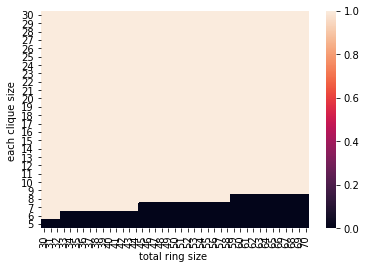

In [32]:
x_val = [i for i in range(30,71)]
y_val = [i for i in range(5,31)]
y_val.reverse()
matrix_ans = []
for y in y_val:
    temp = []
    for x in x_val:
        graph = ring_of_clique(x,y)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == x):
            temp.append(1)
        elif(len(part) < x):
            temp.append(0)
        else:
            temp.append(2)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("total ring size ")
plt.ylabel("each clique size ")
plt.show()

## Maxperm

x : between 55 , 60 ... 100, total ring size 

y : between 3 - 30, each clique size

1 => Some of the cliques were merged together

0 => None of the cliques were merged together

2 => not even those small cliques were identified correctly

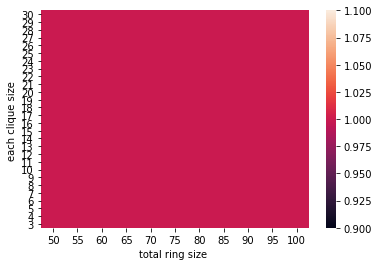

In [46]:
x_val = [i*5 for i in range(10,21)]
y_val = [i for i in range(3,31)]
matrix_ans = []
y_val.reverse()
for y in y_val:
    temp = []
    for x in x_val:
        graph = ring_of_clique(x,y)
        part = run_maxperm(graph[0],graph[1])
        if(len(part) == x):
            temp.append(1)
        elif(len(part) < x):
            temp.append(0)
        else:
            temp.append(2)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("total ring size ")
plt.ylabel("each clique size ")
plt.show()

# One clique surrounded by others(Generalized)

## Modularity

### CASE 1 varying x and y

x : between 30,35 ... 100, total ring size 

y : between 7 - 30, each clique size

alpha : 10, number of outer cliques

beta : 7, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases

https://www.desmos.com/calculator/5r82070boc

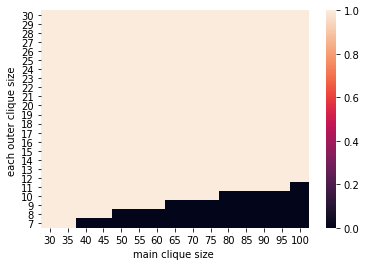

In [25]:
x_val = [i*5 for i in range(6,21)]
y_val = [i for i in range(7,31)]
alpha = 5
beta = 4
y_val.reverse()
matrix_ans = []
for y in y_val:
    temp = []
    for x in x_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in part[j]):
                        if(max(part[j]) in range(x)):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(2)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("main clique size ")
plt.ylabel("each outer clique size ")
plt.show()

In [ ]:
x_val = [i*5 for i in range(6,21)]
y_val = [i for i in range(7,31)]
alpha = 5
beta = 4
y_val.reverse()
matrix_ans = []
for y in y_val:
    temp = []
#     print(y)
    for x in x_val:
#         print(x,end = " ")
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_spinglass(graph[0],graph[1],2)
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in part[j]):
                        if(max(part[j]) in range(x)):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(0)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("main clique size ")
plt.ylabel("each outer clique size ")
plt.show()

In [ ]:
x_val = [i*5 for i in range(6,21)]
y_val = [i for i in range(7,31)]
alpha = 5
beta = 4
y_val.reverse()
matrix_ans = []
for y in y_val:
    temp = []
#     print(y)
    for x in x_val:
#         print(x,end = " ")
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_spinglass(graph[0],graph[1],1)
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in part[j]):
                        if(max(part[j]) in range(x)):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(0)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("main clique size ")
plt.ylabel("each outer clique size ")
plt.show()

In [ ]:
x_val = [i*5 for i in range(6,21)]
y_val = [i for i in range(7,31)]
alpha = 5
beta = 4
y_val.reverse()
matrix_ans = []
for y in y_val:
    temp = []
#     print(y)
    for x in x_val:
#         print(x,end = " ")
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in part[j]):
                        if(max(part[j]) in range(x)):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(0)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("main clique size ")
plt.ylabel("each outer clique size ")
plt.show()

In [ ]:
x_val = [i*5 for i in range(6,21)]
y_val = [i for i in range(7,31)]
alpha = 5
beta = 4
y_val.reverse()
matrix_ans = []
for y in y_val:
    temp = []
#     print(y)
    for x in x_val:
#         print(x,end = " ")
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_spinglass(graph[0],graph[1],0.5)
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in part[j]):
                        if(max(part[j]) in range(x)):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(0)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("main clique size ")
plt.ylabel("each outer clique size ")
plt.show()

In [53]:
graph = comm_surr_comm(40,20,5,4)
part = run_spinglass(graph[0],graph[1],2)
print(part)
print(len(part) == (alpha + 1))

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [15], 16: [16], 17: [17], 18: [18], 19: [19], 20: [20], 21: [21], 22: [22], 23: [23], 24: [24], 25: [25], 26: [26], 27: [27], 28: [28], 29: [29], 30: [30], 31: [31], 32: [32], 33: [33], 34: [34], 35: [35], 36: [36], 37: [37], 38: [38], 39: [39], 40: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], 41: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79], 42: [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 43: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119], 44: [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139]}
False


In [35]:
graph = comm_surr_comm(40,9,5,4)
part = run_louvain(graph[0],graph[1])
print(part)

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 1: [40, 41, 42, 43, 44, 45, 46, 47, 48], 2: [49, 50, 51, 52, 53, 54, 55, 56, 57], 3: [58, 59, 60, 61, 62, 63, 64, 65, 66], 4: [67, 68, 69, 70, 71, 72, 73, 74, 75], 5: [76, 77, 78, 79, 80, 81, 82, 83, 84]}


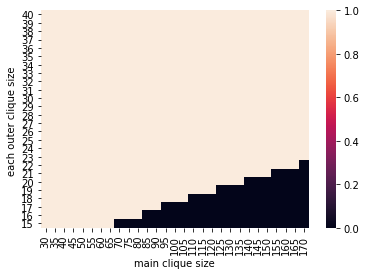

In [48]:
x_val = [i*5 for i in range(6,35)]
y_val = [i for i in range(15,41)]
alpha = 10
beta = 15
matrix_ans = []
y_val.reverse()
for y in y_val:
    temp = []
    for x in x_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in j):
                        if(max(j) < x):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(2)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("main clique size")
plt.ylabel("each outer clique size ")
plt.show()

### CASE 2 varying alpha and beta

x : 100, total ring size 

y : 10, each clique size

alpha : 2 - 30, number of outer cliques

beta : 1 - 10, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases

https://www.desmos.com/calculator/z32db1ohpb

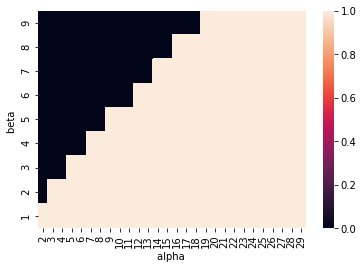

In [49]:
alpha_val = [i for i in range(2,30)]
beta_val = [i for i in range(1,10)]
beta_val.reverse()
x = 100
y = 10
matrix_ans = []
for beta in beta_val:
    temp = []
    for alpha in alpha_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_louvain(graph[0],graph[1])
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in j):
                        if(max(j) < x):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(2)
#         print(part,flag)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=alpha_val, yticklabels=beta_val)
plt.xlabel("alpha ")
plt.ylabel("beta ")
plt.show()

### CASE 3 varying x and beta

alpha : 15, total ring size 

y : 30, each clique size

x : 15 - 50, inner clique size

beta : 1 - 30, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases

https://www.desmos.com/calculator/wegcen1fge

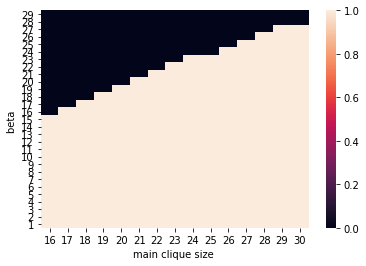

In [50]:
x_val = [i for i in range(16,31)]
beta_val = [i for i in range(1,30)]
beta_val.reverse()
alpha = 15
y = 30
matrix_ans = []
for beta in beta_val:
    temp = []
    for x in x_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_louvain(graph[0],graph[1])
#         print(part)
        if(len(part) == alpha):
            temp.append(0)  
        elif(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in j):
                        if(max(j) < x):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(2)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=beta_val)
plt.xlabel("main clique size ")
plt.ylabel("beta ")
plt.show()

In [51]:
graph = comm_surr_comm(32,y,alpha,19)
part = run_louvain(graph[0],graph[1])
print(part)

Clustering with 482 elements and 16 clusters
[ 0] 0, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
     49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61
[ 1] 1, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
     79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91
[ 2] 2, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,
     107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121
[ 3] 3, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
     136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
     150, 151
[ 4] 4, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
     166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
     180, 181
[ 5] 5, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
     196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
     210, 211
[ 6] 6, 212, 213, 214, 215, 216, 217

### CASE 4 varying y and beta

alpha : 20, total ring size 

y : 20 - 40, each clique size

x : 15, inner clique size

beta : 1 - 20, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases

https://www.desmos.com/calculator/rrkzhltosb

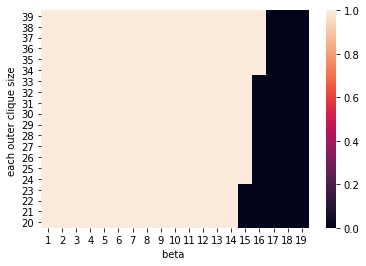

In [52]:
y_val = [i for i in range(20,40)]
beta_val = [i for i in range(1,20)]
y_val.reverse()
alpha = 10
x = 15
matrix_ans = []
for y in y_val:
    temp = []
    for beta in beta_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_louvain(graph[0],graph[1])
#         if(y == 31):
#             print(part)
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in j):
                        if(max(j) < x):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
#             print(x,y,alpha,beta,flag)
            temp.append(flag)
    
        else:
            temp.append(2)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=beta_val, yticklabels=y_val)
plt.xlabel("beta ")
plt.ylabel("each outer clique size ")
plt.show()

In [53]:
graph = comm_surr_comm(15,31,10,11)
part = run_louvain(graph[0],graph[1])
print(part)

Clustering with 325 elements and 11 clusters
[ 0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
[ 1] 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
     33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45
[ 2] 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
     64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76
[ 3] 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
     95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107
[ 4] 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
     122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
     136, 137, 138
[ 5] 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
     153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
     167, 168, 169
[ 6] 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
     184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
     1

## Maxperm

### CASE 1 varying x and y

x : between 30,35 ... 100, total main clique size 

y : between 7 - 30, each clique size

alpha : 10, number of outer cliques

beta : 7, number of edges between main and each outer clique

1 => none of the nodes in main clique merged with outside cliques

0 => each node from main clique merged into its respective clique

2 => exception cases

20
19
18
17
16
15
14
13
12
11
10
9
8
7


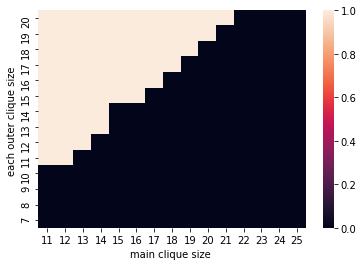

In [75]:
x_val = [i for i in range(11,26)]
y_val = [i for i in range(7,21)]
alpha = 10
beta = 7
y_val.reverse()
matrix_ans = []
for y in y_val:
    print(y)
    temp = []
    for x in x_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_maxperm(graph[0],graph[1])
        flag = 1
        for i in range(x):
            for j in part:
                if(i in part[j]):
                    if(max(part[j]) in range(x)):
                        continue
                    else:
                        flag = 0
                        break
            if(flag == 0):
                break
        temp.append(flag)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.ylabel("each outer clique size ")
plt.xlabel("main clique size ")
plt.show()

In [73]:
graph = comm_surr_comm(10,15,10,7)
part = run_maxperm(graph[0],graph[1])

### CASE 2 varying alpha and beta

x : 100, main clique size 

y : 10, each clique size

alpha : 2 - 30, number of outer cliques

beta : 1 - 10, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases

9 8 7 6 5 4 3 2 1 

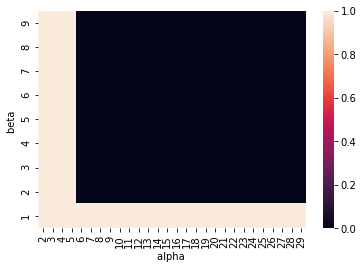

In [76]:
alpha_val = [i for i in range(2,30)]
beta_val = [i for i in range(1,10)]
beta_val.reverse()
x = 60
y = 10
matrix_ans = []
for beta in beta_val:
    temp = []
    print(beta,end = " ")
    for alpha in alpha_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_maxperm(graph[0],graph[1])
        flag = 1
        for i in range(x):
            for j in part:
                if(i in part[j]):
                    if(max(part[j]) in range(x)):
                        continue
                    else:
                        flag = 0
                        break
            if(flag == 0):
                break
        temp.append(flag)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=alpha_val, yticklabels=beta_val)
plt.ylabel("beta ")
plt.xlabel("alpha ")
plt.show()

### CASE 3 varying x and beta

alpha : 15, main clique size 

y : 30, each clique size

x : 15 - 50, inner clique size

beta : 1 - 30, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases

29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 

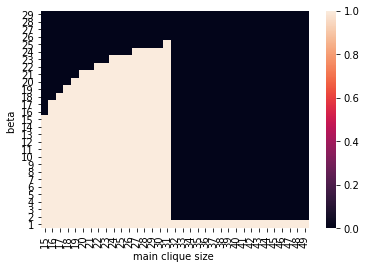

In [77]:
x_val = [i for i in range(15,50)]
beta_val = [i for i in range(1,30)]
beta_val.reverse()
alpha = 15
y = 30
matrix_ans = []
for beta in beta_val:
    temp = []
    print(beta,end = " ")
    for x in x_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_maxperm(graph[0],graph[1])
        flag = 1
        for i in range(x):
            for j in part:
                if(i in part[j]):
                    if(max(part[j]) in range(x)):
                        continue
                    else:
                        flag = 0
                        break
            if(flag == 0):
                break
        temp.append(flag)

            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=beta_val)
plt.ylabel("beta ")
plt.xlabel("main clique size ")
plt.show()

### CASE 4 varying y and beta

alpha : 20, main clique size 

y : 20 - 40, each clique size

x : 15, inner clique size

beta : 1 - 20, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases

39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 

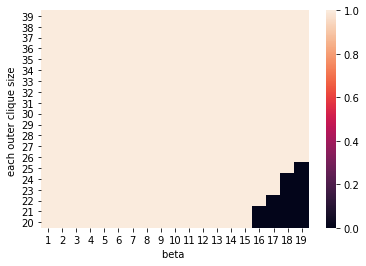

In [78]:
y_val = [i for i in range(20,40)]
beta_val = [i for i in range(1,20)]
y_val.reverse()
alpha = 10
x = 15
matrix_ans = []
for y in y_val:
    temp = []
    print(y,end = " ")
    for beta in beta_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_maxperm(graph[0],graph[1])
        flag = 1
        for i in range(x):
            for j in part:
                if(i in part[j]):
                    if(max(part[j]) in range(x)):
                        continue
                    else:
                        flag = 0
                        break
            if(flag == 0):
                break
        temp.append(flag)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=beta_val, yticklabels=y_val)
plt.xlabel("beta ")
plt.ylabel("each outer clique size ")
plt.show()

# Hub Node (generic)

## label propagation

### CASE 1: Varying x and y  (btw 5 - 24) with constant alpha = 10 and beta = 10

1 => hub node was merged with left community

0 => hub node was merged with right community

2 => whole graph was considered as one community


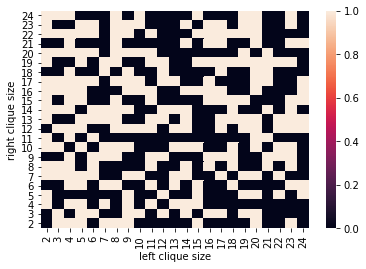

In [36]:
x_val = [i for i in range(2,25)]
y_val = [i for i in range(2,25)]
y_val.reverse()
alpha = 10
beta = 10
matrix_ans = []
for j in y_val:
    temp = []
    for i in x_val:
        graph = hub_node_generic(i,j,alpha,beta)
        part = run_label_prop(graph[0],graph[1])
        if(len(part) == 1):
            temp.append(2)
            continue;
        if(0 in part[0] and 1 in part[0]):
            temp.append(1)
        elif(0  in part[1] and 1 in part[1]):
            temp.append(1)
        else:
            temp.append(0)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("left clique size")
plt.ylabel("right clique size")
plt.show()

### CASE 2: Varying alpha and beta (btw 5 -24) with constant x = 50 and y = 50

1 => hub node was merged with left community

0 => hub node was merged with right community

2 => whole graph was considered as one community


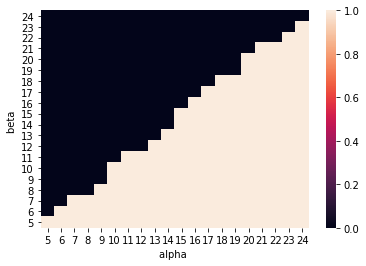

In [37]:
alpha_val = [i for i in range(5,25)]
beta_val = [i for i in range(5,25)]
beta_val.reverse()
x = 50
y = 50
matrix_ans = []
for beta in beta_val:
    temp = []
    for alpha in alpha_val:
        graph = hub_node_generic(x,y,alpha,beta)
        part = run_label_prop(graph[0],graph[1])
        if(len(part) == 1):
            temp.append(2)
            continue;
        if(0 in part[0] and 1 in part[0]):
            temp.append(1)
        elif(0  in part[1] and 1 in part[1]):
            temp.append(1)
        else:
            temp.append(0)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=alpha_val, yticklabels=beta_val)
plt.xlabel("alpha ")
plt.ylabel("beta ")
plt.show()

### CASE 3: Varying alpha and x  with constant y = 50 and beta = 10

x : 5 10 .. 100 

alpha : 5 - 50

1 => hub node was merged with left community

0 => hub node was merged with right community

2 => whole graph was considered as one community


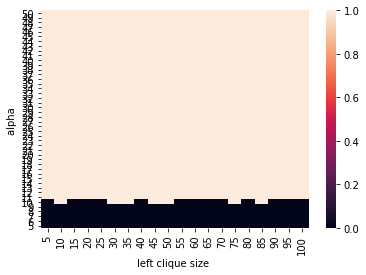

In [38]:
alpha_val = [i for i in range(5,51)]
x_val = [i*5 for i in range(1,21)]
alpha_val.reverse()
beta = 10
y = 50
matrix_ans = []
for alpha in alpha_val:
    temp = []
    for x in x_val:
        graph = hub_node_generic(x,y,alpha,beta)
        part = run_label_prop(graph[0],graph[1])
        if(len(part) == 1):
            temp.append(2)
            continue;
        if(0 in part[0] and 1 in part[0]):
            temp.append(1)
        elif(0  in part[1] and 1 in part[1]):
            temp.append(1)
        else:
            temp.append(0)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=alpha_val)
plt.xlabel("left clique size ")
plt.ylabel("alpha ")
plt.show()

# Ring of Cliques

## label propagation

x : between 55 , 60 ... 100, total ring size 

y : between 3 - 30, each clique size

1 => Some of the cliques were merged together

0 => None of the cliques were merged together

2 => not even those small cliques were identified correctly


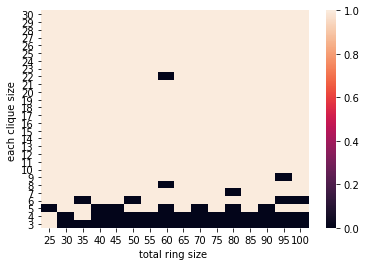

In [39]:
x_val = [i*5 for i in range(5,21)]
y_val = [i for i in range(3,31)]
y_val.reverse()
matrix_ans = []
for y in y_val:
    temp = []
    for x in x_val:
        graph = ring_of_clique(x,y)
        part = run_label_prop(graph[0],graph[1])
        if(len(part) == x):
            temp.append(1)
        elif(len(part) < x):
            temp.append(0)
        else:
            temp.append(2)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("total ring size ")
plt.ylabel("each clique size ")
plt.show()

# One clique surrounded by others(Generalized)

## label propagation

### CASE 1 varying x and y

x : between 30,35 ... 100, total ring size 

y : between 7 - 30, each clique size

alpha : 10, number of outer cliques

beta : 7, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases


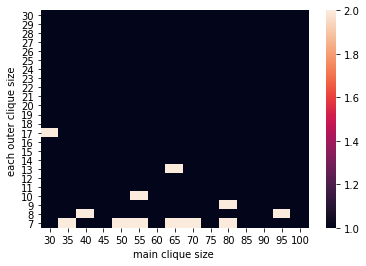

In [40]:
x_val = [i*5 for i in range(6,21)]
y_val = [i for i in range(7,31)]
alpha = 10
beta = 7
y_val.reverse()
matrix_ans = []
for y in y_val:
    temp = []
    for x in x_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_label_prop(graph[0],graph[1])
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in part[j]):
                        if(max(part[j]) in range(x)):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(2)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("main clique size ")
plt.ylabel("each outer clique size ")
plt.show()

### CASE 2 varying alpha and beta

x : 100, total ring size 

y : 10, each clique size

alpha : 2 - 30, number of outer cliques

beta : 1 - 10, number of edges between main and each outer clique

1 => each and every clique were correctly identified

0 => each node from main clique merged into its respective clique

2 => exception cases


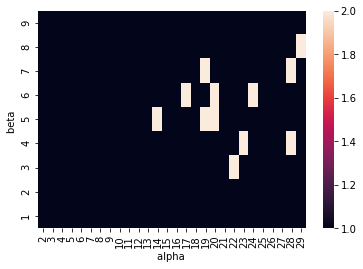

In [41]:
alpha_val = [i for i in range(2,30)]
beta_val = [i for i in range(1,10)]
beta_val.reverse()
x = 100
y = 10
matrix_ans = []
for beta in beta_val:
    temp = []
    for alpha in alpha_val:
        graph = comm_surr_comm(x,y,alpha,beta)
        part = run_label_prop(graph[0],graph[1])
        if(len(part) == (alpha + 1)):
            flag = 1
            for i in range(x):
                for j in part:
                    if(i in part[j]):
                        if(max(part[j]) < x):
                            continue
                        else:
                            flag = 0
                            break
                if(flag == 0):
                    break
            temp.append(flag)
    
        else:
            temp.append(2)
#         print(part,flag)
            
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=alpha_val, yticklabels=beta_val)
plt.xlabel("alpha ")
plt.ylabel("beta ")
plt.show()

# Spinglass

### CASE 1: Varying x and y (btw 5 -24) with constant alpha = 20 and beta = 20, gamma = 0.5

1 => hub node was merged with left community

0 => hub node was merged with right community

2 => whole graph was considered as one community


23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 

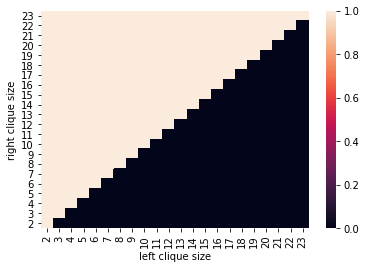

In [43]:
x_val = [i for i in range(2,24)]
y_val = [i for i in range(2,24)]
y_val.reverse()
alpha = 20
beta = 20
matrix_ans = []
for j in y_val:
    temp = []
    print(j,end = " ")
    for i in x_val:
        graph = hub_node_generic(i,j,alpha,beta)
        part = run_spinglass(graph[0],graph[1], 0.5)
        if(len(part) == 1):
            temp.append(2)
            continue;
#         print(part)
        if(0 in part[0] and 1 in part[0]):
            temp.append(1)
        elif(0  in part[1] and 1 in part[1]):
            temp.append(1)
        else:
            temp.append(0)
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("left clique size")
plt.ylabel("right clique size")
plt.show()

# Ring of Cliques

## spinglass


x : between 55 , 60 ... 100, total ring size 

y : between 3 - 30, each clique size

1 => Some of the cliques were merged together

0 => None of the cliques were merged together

2 => not even those small cliques were identified correctly



In [46]:
x_val = [i for i in range(10,11)]
y_val = [i for i in range(3,4)]
y_val.reverse()
matrix_ans = []
for x in x_val:
    print(y,end = " ")
    temp = []
    y = 3
    while True:
        graph = ring_of_clique(x,y)
        part = run_spinglass(graph[0],graph[1],1)
        print(len(part),x,y,"%%%% ",end = " ")
        if(len(part) == x):
            temp.append(1)
        elif(len(part) < x):
            temp.append(0)
            break
        else:
            temp.append(2)
            print(x,y)
            break
        y += 1
    matrix_ans.append(temp)

sns.heatmap(matrix_ans,xticklabels=x_val, yticklabels=y_val)
plt.xlabel("total ring size ")
plt.ylabel("each clique size ")
plt.show()

NameError: name 'y' is not defined

In [ ]:
graph = ring_of_clique(200,3)
part = run_spinglass(graph[0],graph[1],1)
Print(graph[0],graph[1])
print(part)
for i in part:
    print(part[i])

In [ ]:

G = nx.karate_club_graph()
karate = load("karate.gml")
# print(karate)
edges = []
for i in G.edges():
    source = i[0]
    dest = i[1]
#     print(source,dest)
    edges.append((source,dest))

part = run_louvain(34,edges)
print("LOUVAIN")
print(part)
circ_pos = nx.circular_layout(G)
nx.draw_circular(G, with_labels=True)
nx.draw_networkx_nodes(G,circ_pos, nodelist=part[0], node_color='g', alpha=0.5)
nx.draw_networkx_nodes(G,circ_pos, nodelist=part[1], node_color='r', alpha=0.5)
nx.draw_networkx_nodes(G,circ_pos, nodelist=part[2], node_color='b', alpha=0.5)
nx.draw_networkx_nodes(G,circ_pos, nodelist=part[3], node_color='orange', alpha=0.5)
plt.show()

## Maxperm

In [ ]:
plt.close()
part = run_maxperm(34,edges)
circ_pos = nx.circular_layout(G)
nx.draw_circular(G, with_labels=True)
print("MAXPERM")
for i in part:
    print i,": ",
    print(sorted(list(part[i])))
nx.draw_networkx_nodes(G,circ_pos, nodelist=sorted(part[16]), node_color='green', alpha=0.5)
nx.draw_networkx_nodes(G,circ_pos, nodelist=sorted(part[32]), node_color='r', alpha=0.5)
nx.draw_networkx_nodes(G,circ_pos, nodelist=sorted(part[10]), node_color='blue', alpha=0.5)
nx.draw_networkx_nodes(G,circ_pos, nodelist=sorted(part[25]), node_color='black', alpha=0.5)
nx.draw_networkx_nodes(G,circ_pos, nodelist=sorted(part[12]), node_color='pink', alpha=0.5)
plt.show()